In [7]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 21.7 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [9]:
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 5.9 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [11]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 40.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 4.4 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [37]:
pip install plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 59.1 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

In [15]:
EPOCHS = 20
SAMPLE_LEN = 100
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

<Axes: title={'center': 'Healthy Frequency Count'}, xlabel='healthy'>

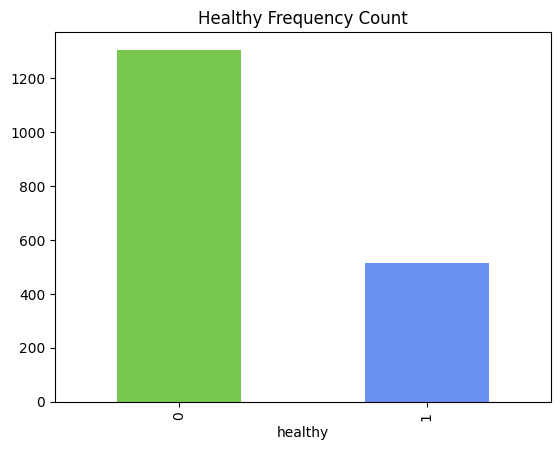

In [16]:
#imbalanced classes for the variable multiple_diseases.
colors=['#78C850','#6890F0']
train_data['healthy'].value_counts().plot(kind='bar',title='Healthy Frequency Count',color=colors)

<Axes: title={'center': 'Multi-Diseases Frequency Count'}, xlabel='multiple_diseases'>

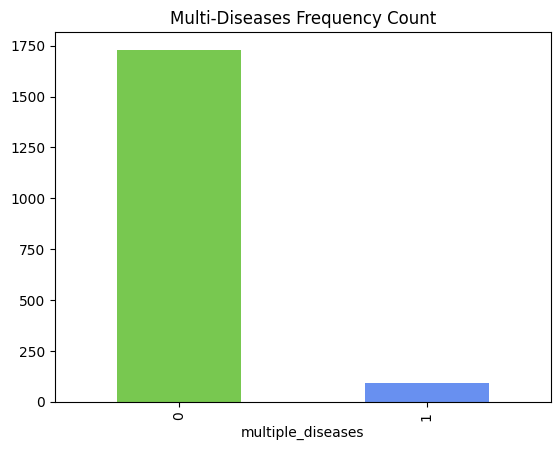

In [17]:
train_data['multiple_diseases'].value_counts().plot(kind='bar',title='Multi-Diseases Frequency Count',color=colors)

<Axes: title={'center': 'Rust Frequency Count'}, xlabel='rust'>

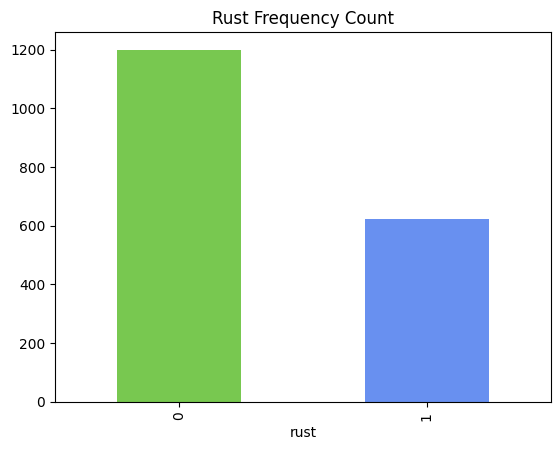

In [18]:
train_data['rust'].value_counts().plot(kind='bar',title='Rust Frequency Count',color=colors)


<Axes: title={'center': 'Scab Frequency Count'}, xlabel='scab'>

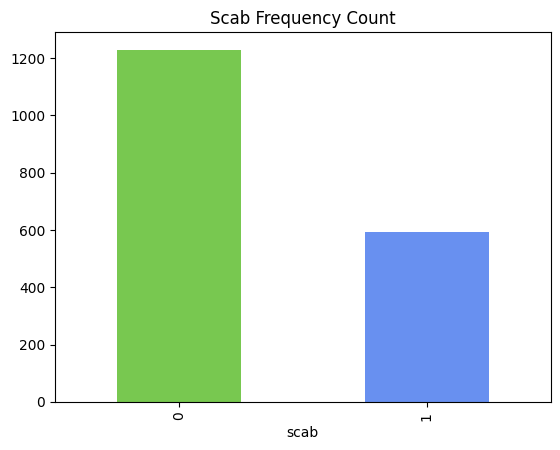

In [19]:
train_data['scab'].value_counts().plot(kind='bar',title='Scab Frequency Count',color=colors)


In [20]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [21]:
test_data.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [22]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


In [23]:
    def visualize_leaves(cond=[0, 0, 0, 0], cond_cols=["healthy"], is_cond=True):
        if not is_cond:
            cols, rows = 3, min([3, len(train_images)//3])
            fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
            for col in range(cols):
                for row in range(rows):
                    ax[row, col].imshow(train_images.loc[train_images.index[-row*3-col-1]])
            return None
            
        cond_0 = "healthy == {}".format(cond[0])
        cond_1 = "scab == {}".format(cond[1])
        cond_2 = "rust == {}".format(cond[2])
        cond_3 = "multiple_diseases == {}".format(cond[3])
        
        cond_list = []
        for col in cond_cols:
            if col == "healthy":
                cond_list.append(cond_0)
            if col == "scab":
                cond_list.append(cond_1)
            if col == "rust":
                cond_list.append(cond_2)
            if col == "multiple_diseases":
                cond_list.append(cond_3)
        
        data = train_data.loc[:100]
        for cond in cond_list:
            data = data.query(cond)
            
        images = train_images.loc[list(data.index)]
        cols, rows = 3, min([3, len(images)//3])
        
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
        for col in range(cols):
            for row in range(rows):
                ax[row, col].imshow(images.loc[images.index[row*3+col]])
        plt.show()

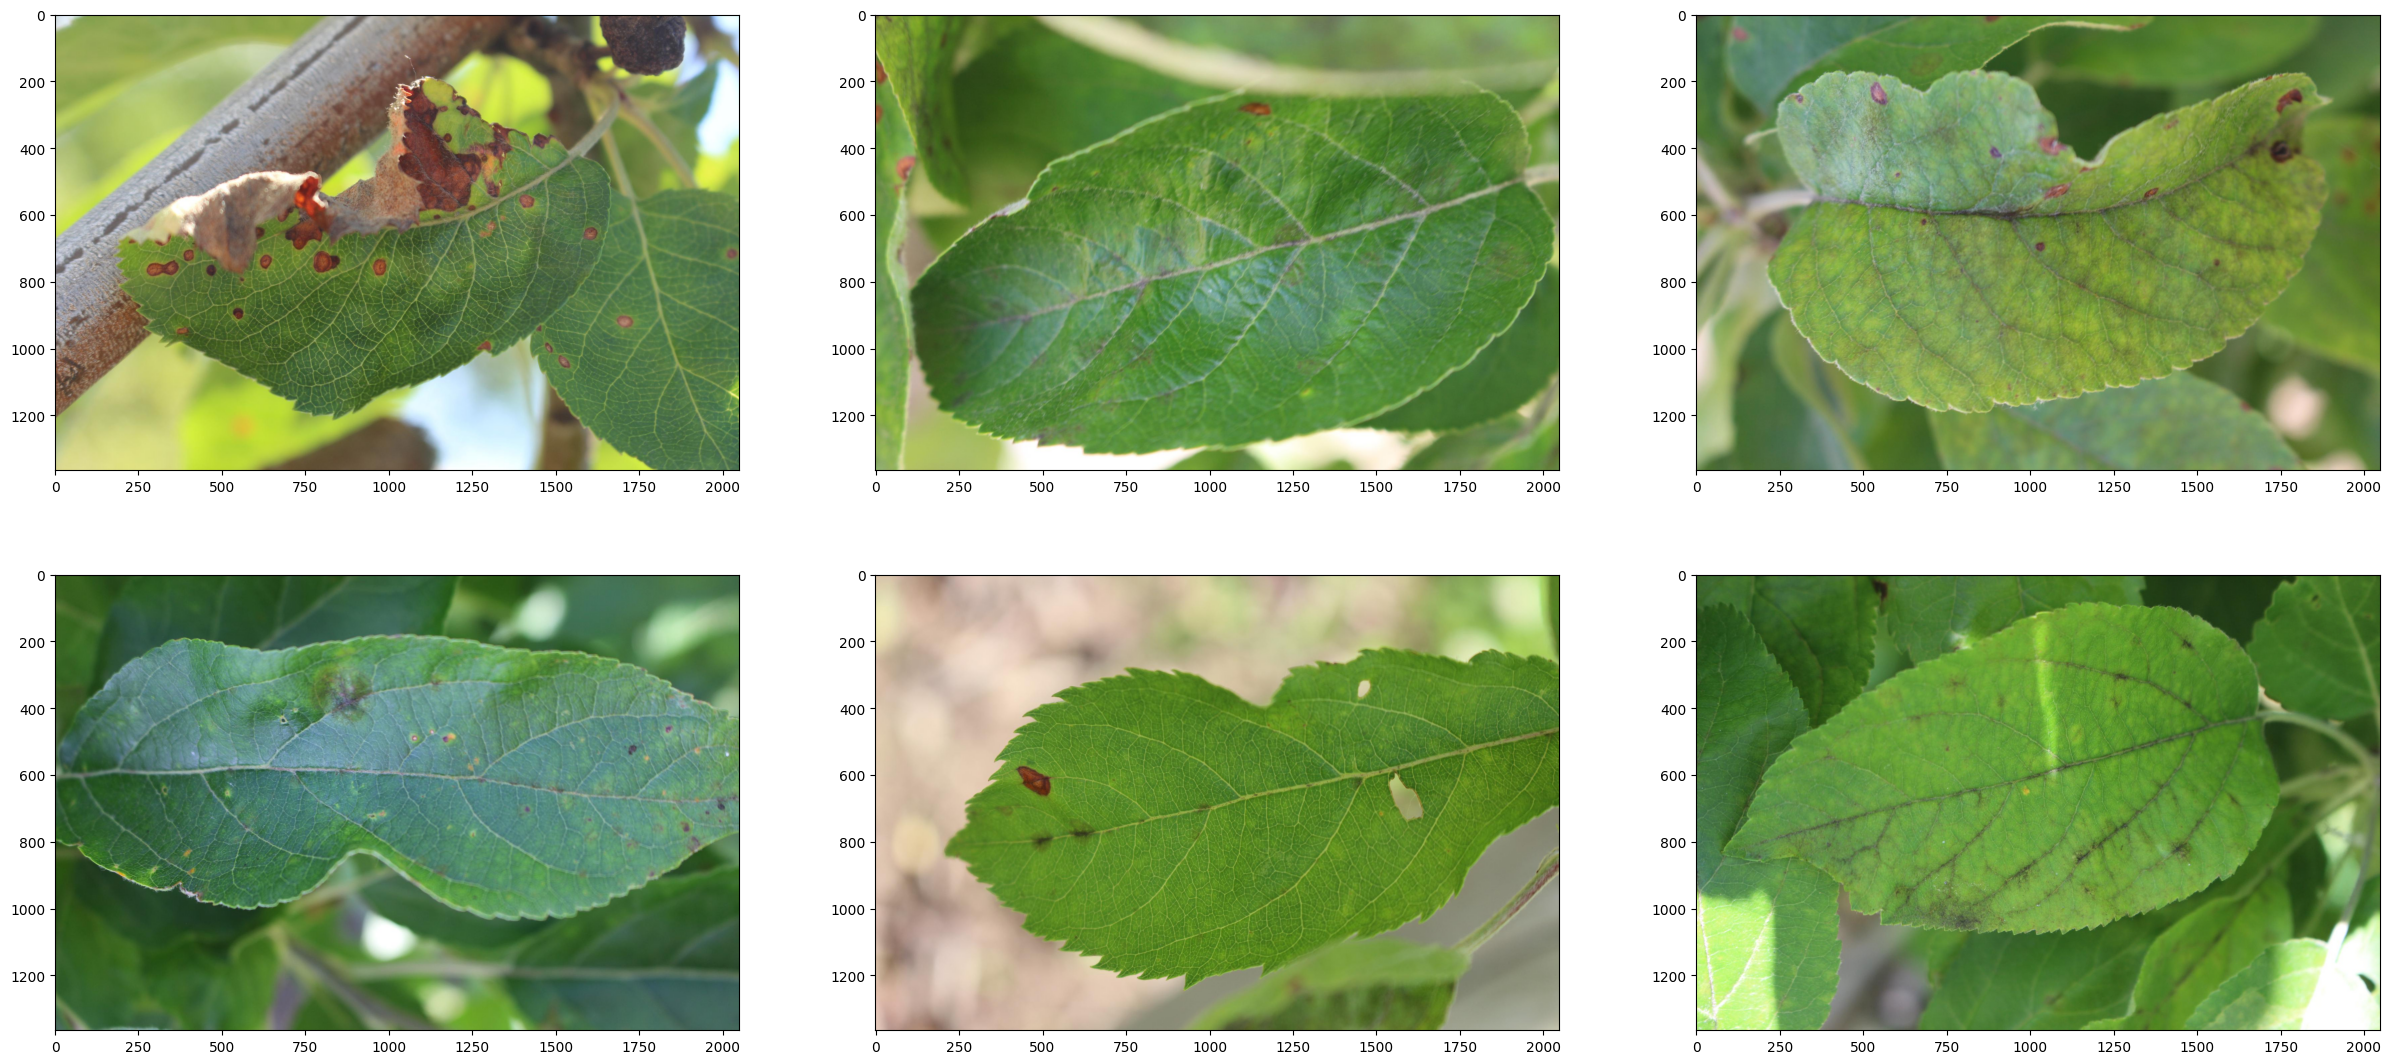

In [24]:
visualize_leaves(cond=[0, 0, 0, 1], cond_cols=["multiple_diseases"])

In [25]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/plant-pathology-2020-fgvc7


In [26]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [27]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [28]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [29]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [30]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [31]:
with strategy.scope():
    model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 16, 16, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [33]:
#SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

In [34]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20


2023-04-30 00:02:59.837483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-30 00:03:01.295810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


12/12 [==============================] - ETA: 0s - loss: 1.5338 - categorical_accuracy: 0.2812

2023-04-30 00:04:37.800127: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-04-30 00:04:38.167590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


12/12 [==============================] - 187s 5s/step - loss: 1.5338 - categorical_accuracy: 0.2812 - val_loss: 1.5840 - val_categorical_accuracy: 0.2774 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 9s 739ms/step - loss: 0.8432 - categorical_accuracy: 0.6478 - val_loss: 1.5065 - val_categorical_accuracy: 0.4927 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 9s 748ms/step - loss: 0.3656 - categorical_accuracy: 0.8861 - val_loss: 1.4324 - val_categorical_accuracy: 0.5912 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 9s 732ms/step - loss: 0.2141 - categorical_accuracy: 0.9316 - val_loss: 1.2782 - val_categorical_accuracy: 0.6971 - lr: 2.4400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/20
12

In [39]:
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [40]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')